# Motor de IA para Análisis y Decisión de Cobranza - Banco de Occidente

Este notebook implementa un prototipo del motor de IA para optimizar estrategias de cobranza bancaria, analizando la cartera y recomendando acciones basadas en datos.

## 1. Importación de Librerías

In [97]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
import joblib

# Configuraciones visuales
warnings.filterwarnings('ignore')
plt.style.use('ggplot')
sns.set(style="whitegrid")

## 2. Carga y Exploración de Datos

In [99]:
# Carga del archivo Excel
file_path = 'R10_ACUMULADA.xlsx'  # Ajusta según donde tengas el archivo
df = pd.read_excel(file_path)

# Información básica del dataset
print(f"Dimensiones del dataset: {df.shape}")
print("\nPrimeras 5 filas:")
display(df.head())

# Resumen estadístico
print("\nResumen estadístico de campos numéricos:")
display(df.describe())

# Tipos de datos
print("\nTipos de datos por columna:")
display(pd.DataFrame(df.dtypes, columns=['Tipo de Dato']))

Dimensiones del dataset: (70, 51)

Primeras 5 filas:


,CEDULA ASOCIADO,NOMBRE ASOCIADO,REGIONAL,ZONA,TIPO CLIENTE,DESCRIPCIÓN DEL CORTE,DESCRIPCIÓN DEL ESTADO MULTIACTIVA HOY,EDAD CARTERA INICIAL,EDAD CARTERA HOY,VALOR RECAUDO VENCIDO,...,Promesa_Cumplida,EDAD_CARTERA_HOMOLOGADA,Revesta,ACR,Alivio_financiero,Gestion_Reciente,Saldo_menor,gestion_base,CONCEPTO MAS VENCIDO,Caida
0,11846855,ANA LUCÍA FERNÁNDEZ RIVAS,Cali,Popayan,Solo Asociado,Al 05 del Mes,Activo Cobranza Interna,3,4,0,...,0,3,SI,NO,NO,GESTIONADO,NO,1,APORTES,7
1,78841527,JUAN PABLO ORTEGA MÉNDEZ,Palmira,Palmira,Solo Asociado,Al 05 del Mes,Activo Cobranza Interna,2,3,0,...,0,2,NO,NO,NO,GESTIONADO,NO,1,APORTES,7
2,17932430,MARÍA FERNANDA LÓPEZ CASTELLANOS,Bogota,Santafe de Bogota D.C.,Mixto (Asociado/Cliente),Al 10 del Mes,Activo Cobranza Interna,0,1,0,...,0,0,NO,NO,NO,SIN_GESTION,NO,0,APORTES,10
3,58561457,CARLOS ANDRÉS PÉREZ MONTOYA,Bogota,Santafe de Bogota D.C.,Mixto (Asociado/Cliente),Al 05 del Mes,Activo Cobranza Interna,0,1,0,...,0,0,NO,NO,NO,GESTIONADO,NO,1,APORTES,7
4,76508236,LAURA SOFÍA GÓMEZ VARGAS,Bogota,Santafe de Bogota D.C.,Solo Asociado,Al 05 del Mes,Activo Cobranza Interna,0,1,0,...,0,0,NO,NO,NO,SIN_GESTION,NO,0,APORTES,7



Resumen estadístico de campos numéricos:


,CEDULA ASOCIADO,EDAD CARTERA INICIAL,EDAD CARTERA HOY,VALOR RECAUDO VENCIDO,VALOR VENCIDO PERIODO,ANTIGUEDAD DEL ASOCIADO EN COOMEVA,EDAD ASOCIADO,TELÉFONO RESIDENCIAL,TELÉFONO CORRESPONDENCIA,TELÉFONO FAMILIAR,...,DIA_CORTE,fecha_ultima_gestion,Contacto,Contacto Directo,Efectivo,Qgestiones,Promesa_Cumplida,EDAD_CARTERA_HOMOLOGADA,gestion_base,Caida
count,7.000000e+01,70.000000,70.000000,7.000000e+01,7.000000e+01,70.000000,70.000000,0.0,0.0,0.0,...,70.000000,61,59.000000,59.000000,59.000000,61.000000,70.000000,70.000000,70.000000,70.000000
mean,5.128526e+07,0.985714,1.528571,1.211587e+05,2.677398e+05,4.542857,15.342857,NaN,NaN,NaN,...,10.357143,2025-04-08 23:36:23.606557440,0.440678,0.271186,0.135593,3.721311,0.028571,0.985714,0.871429,11.614286
min,1.114820e+07,0.000000,0.000000,0.000000e+00,8.487300e+04,0.000000,1.000000,NaN,NaN,NaN,...,5.000000,2025-04-02 00:00:00,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,7.000000
25%,3.242904e+07,0.000000,1.000000,0.000000e+00,8.577500e+04,0.000000,6.000000,NaN,NaN,NaN,...,5.000000,2025-04-09 00:00:00,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,1.000000,7.000000
50%,5.413843e+07,1.000000,1.000000,0.000000e+00,8.577500e+04,2.000000,11.000000,NaN,NaN,NaN,...,5.000000,2025-04-10 00:00:00,0.000000,0.000000,0.000000,3.000000,0.000000,1.000000,1.000000,7.000000
75%,7.004567e+07,2.000000,2.000000,0.000000e+00,1.799080e+05,6.000000,19.750000,NaN,NaN,NaN,...,10.000000,2025-04-10 00:00:00,1.000000,1.000000,0.000000,5.000000,0.000000,2.000000,1.000000,10.000000
max,8.846666e+07,4.000000,5.000000,3.132602e+06,3.132602e+06,30.000000,62.000000,NaN,NaN,NaN,...,30.000000,2025-04-11 00:00:00,1.000000,1.000000,1.000000,9.000000,1.000000,4.000000,1.000000,30.000000
std,2.222144e+07,1.014287,1.176108,4.731153e+05,4.803321e+05,6.800865,14.261416,NaN,NaN,NaN,...,8.223395,NaN,0.500730,0.448388,0.345295,2.222095,0.167802,1.014287,0.337142,7.522513



Tipos de datos por columna:


,Tipo de Dato
CEDULA ASOCIADO,int64
NOMBRE ASOCIADO,object
REGIONAL,object
ZONA,object
TIPO CLIENTE,object
DESCRIPCIÓN DEL CORTE,object
DESCRIPCIÓN DEL ESTADO MULTIACTIVA HOY,object
EDAD CARTERA INICIAL,int64
EDAD CARTERA HOY,int64
VALOR RECAUDO VENCIDO,int64


## 3. Limpieza y Preparación de Datos

In [101]:
# Hacemos una copia para no modificar los datos originales
df_clean = df.copy()

# Verificar valores nulos
print("Valores nulos por columna:")
display(pd.DataFrame(df_clean.isna().sum(), columns=['Nulos']))

# Rellenar valores nulos en columnas relevantes
# Para valores numéricos usamos 0, para strings usamos 'No disponible'
for col in df_clean.columns:
    if df_clean[col].dtype == 'object':
        df_clean[col].fillna('No disponible', inplace=True)
    else:
        df_clean[col].fillna(0, inplace=True)

Valores nulos por columna:


,Nulos
CEDULA ASOCIADO,0
NOMBRE ASOCIADO,0
REGIONAL,0
ZONA,0
TIPO CLIENTE,0
DESCRIPCIÓN DEL CORTE,0
DESCRIPCIÓN DEL ESTADO MULTIACTIVA HOY,0
EDAD CARTERA INICIAL,0
EDAD CARTERA HOY,0
VALOR RECAUDO VENCIDO,0


## 4. Implementación de Estrategia de Filtrado

In [103]:
def aplicar_estrategia_filtrado(data):
    """
    Aplica los filtros de la estrategia de cobranza actual
    """
    print(f"Registros iniciales: {len(data)}")
    
    # Crear una copia para no modificar el original
    df_filtrado = data.copy()
    
    # 1. Filtrado por edad de cartera (EDAD_CARTERA_HOMOLOGADA = 0 o 1)
    mask_edad = (df_filtrado['EDAD_CARTERA_HOMOLOGADA'].isin([0, 1]))
    df_filtrado = df_filtrado[mask_edad]
    print(f"Después de filtro por EDAD_CARTERA_HOMOLOGADA: {len(df_filtrado)}")
    
    # 2. Eliminar registros inactivos
    mask_activos = ~df_filtrado['DESCRIPCIÓN DEL ESTADO MULTIACTIVA HOY'].astype(str).str.contains('Inactivo')
    df_filtrado = df_filtrado[mask_activos]
    print(f"Después de filtro por estado inactivo: {len(df_filtrado)}")
    
    # 3. Excluir registros al día (EDAD CARTERA HOY = 0)
    mask_mora = (df_filtrado['EDAD CARTERA HOY'] != 0)
    df_filtrado = df_filtrado[mask_mora]
    print(f"Después de filtro por EDAD CARTERA HOY: {len(df_filtrado)}")
    
    # 4. Eliminar registros con estado MANTENIDO
    mask_estado = (df_filtrado['ESTADO_CARTERA'] != 'MANTENIDO')
    df_filtrado = df_filtrado[mask_estado]
    print(f"Después de filtro por ESTADO_CARTERA: {len(df_filtrado)}")
    
    # 5. Excluir registros con "Promesa pendiente"
    mask_promesa = (df_filtrado['Estado_compromiso'] != 'Promesa pendiente')
    df_filtrado = df_filtrado[mask_promesa]
    print(f"Después de filtro por Estado_compromiso: {len(df_filtrado)}")
    
    # 6. Eliminar registros con saldo menor
    mask_saldo = (df_filtrado['Saldo_menor'] != 'SI')
    df_filtrado = df_filtrado[mask_saldo]
    print(f"Después de filtro por Saldo_menor: {len(df_filtrado)}")
    
    # 7. Filtros estratégicos adicionales
    
    # 7.1 Identificar registros prioritarios (Promesa rota o Promesa hoy)
    mask_prioritarios = df_filtrado['Estado_compromiso'].isin(['Promesa rota', 'Promesa Hoy'])
    df_prioritarios = df_filtrado[mask_prioritarios].copy()
    print(f"Registros prioritarios (Promesa rota/hoy): {len(df_prioritarios)}")
    
    # 7.2 Filtrar registros con respuestas no efectivas en los últimos 3 días
    codigos_no_efectivos = [
        'TELEFONO_ERRADO',
        'SIN_ACUERDO_DE_PAGO',
        'DEJA_MENSAJE_CON_TERCERO',
        'NO_CONTESTA',
        'TELEFONO_DANADO',
        'VOLVER_A_LLAM_LLAMAR_DESP'
    ]
    
    # Excluir registros no prioritarios con gestiones no efectivas recientes
    df_no_prioritarios = df_filtrado[~mask_prioritarios].copy()
    
    # En un escenario real se filtrarían por fecha, pero para la demo usamos todos
    # ya que tenemos pocos datos y podría eliminar demasiados registros
    
    mask_excluir = df_no_prioritarios['Respuesta'].isin(codigos_no_efectivos)
    df_no_prioritarios = df_no_prioritarios[~mask_excluir]
    print(f"Registros no prioritarios después de filtrar respuestas no efectivas: {len(df_no_prioritarios)}")
    
    # Combinar registros prioritarios con el resto
    df_filtrado_final = pd.concat([df_prioritarios, df_no_prioritarios])
    
    # 8. Ordenar por prioridad de gestión
    # Extraer el número de la prioridad para ordenar numéricamente
    df_filtrado_final['nivel_prioridad'] = df_filtrado_final['PRIORIDAD_GESTION'].str.extract('(\d+)').astype(int)
    df_filtrado_final = df_filtrado_final.sort_values('nivel_prioridad')
    df_filtrado_final = df_filtrado_final.drop('nivel_prioridad', axis=1)
    
    print(f"Total de registros filtrados: {len(df_filtrado_final)}")
    return df_filtrado_final

# Aplicar la estrategia de filtrado
df_filtrado = aplicar_estrategia_filtrado(df_clean)

# Mostrar los resultados filtrados
display(df_filtrado.head())

Registros iniciales: 70
Después de filtro por EDAD_CARTERA_HOMOLOGADA: 51
Después de filtro por estado inactivo: 51
Después de filtro por EDAD CARTERA HOY: 42
Después de filtro por ESTADO_CARTERA: 42
Después de filtro por Estado_compromiso: 41
Después de filtro por Saldo_menor: 41
Registros prioritarios (Promesa rota/hoy): 3
Registros no prioritarios después de filtrar respuestas no efectivas: 14
Total de registros filtrados: 17


,CEDULA ASOCIADO,NOMBRE ASOCIADO,REGIONAL,ZONA,TIPO CLIENTE,DESCRIPCIÓN DEL CORTE,DESCRIPCIÓN DEL ESTADO MULTIACTIVA HOY,EDAD CARTERA INICIAL,EDAD CARTERA HOY,VALOR RECAUDO VENCIDO,...,Promesa_Cumplida,EDAD_CARTERA_HOMOLOGADA,Revesta,ACR,Alivio_financiero,Gestion_Reciente,Saldo_menor,gestion_base,CONCEPTO MAS VENCIDO,Caida
4,76508236,LAURA SOFÍA GÓMEZ VARGAS,Bogota,Santafe de Bogota D.C.,Solo Asociado,Al 05 del Mes,Activo Cobranza Interna,0,1,0,...,0,0,NO,NO,NO,SIN_GESTION,NO,0,APORTES,7
6,17607105,VALENTINA TORRES HIDALGO,Medellin,Medellin,Mixto (Asociado/Cliente),Al 05 del Mes,Activo Cobranza Interna,0,1,0,...,0,0,SI,NO,NO,GESTIONADO,NO,1,APORTES,7
65,82515538,ALFREDO VALENCIA GONZÁLEZ,Caribe,Valledupar,Solo Asociado,Al 10 del Mes,Activo Cobranza Interna,0,1,0,...,0,0,NO,NO,NO,SIN_GESTION,NO,0,APORTES,10
62,57860363,LAURA SUAREZ MEJÍA,Caribe,Valledupar,Mixto (Asociado/Cliente),Al 05 del Mes,Activo Cobranza Interna,0,1,0,...,0,0,NO,NO,NO,GESTIONADO,NO,1,APORTES,7
66,52538299,LORENA TORRES CUÉLLAR,Medellin,Medellin,Mixto (Asociado/Cliente),Al 25 del Mes,Activo Cobranza Interna,1,1,0,...,0,1,NO,NO,NO,GESTIONADO,NO,1,APORTES,25


## 5. Análisis de Contactabilidad y Efectividad

Tasa de contactabilidad: 22.86%
Tasa de efectividad: 50.00%


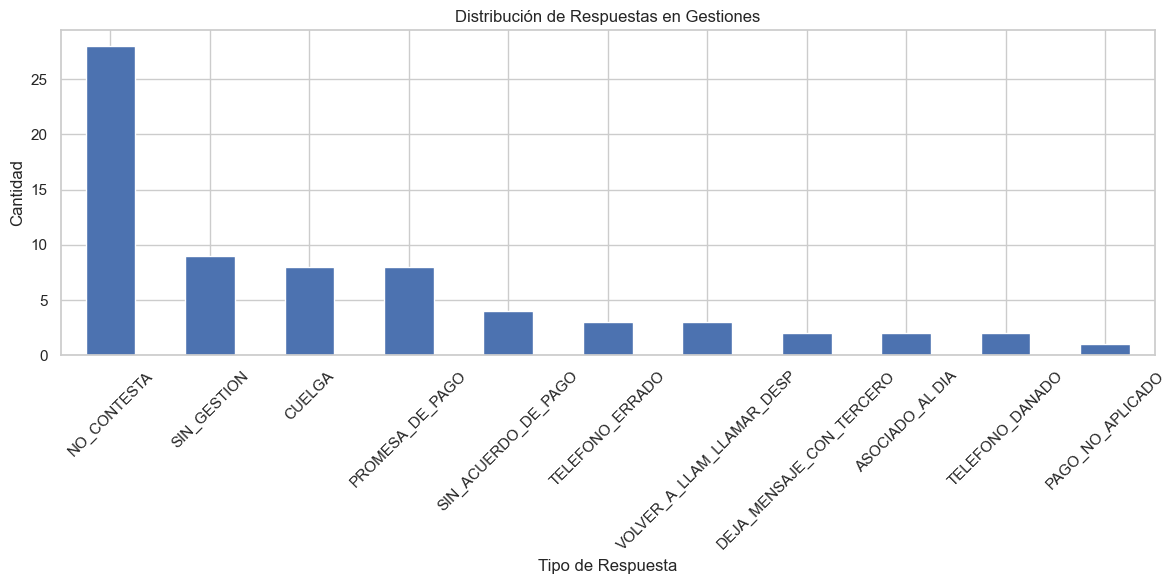

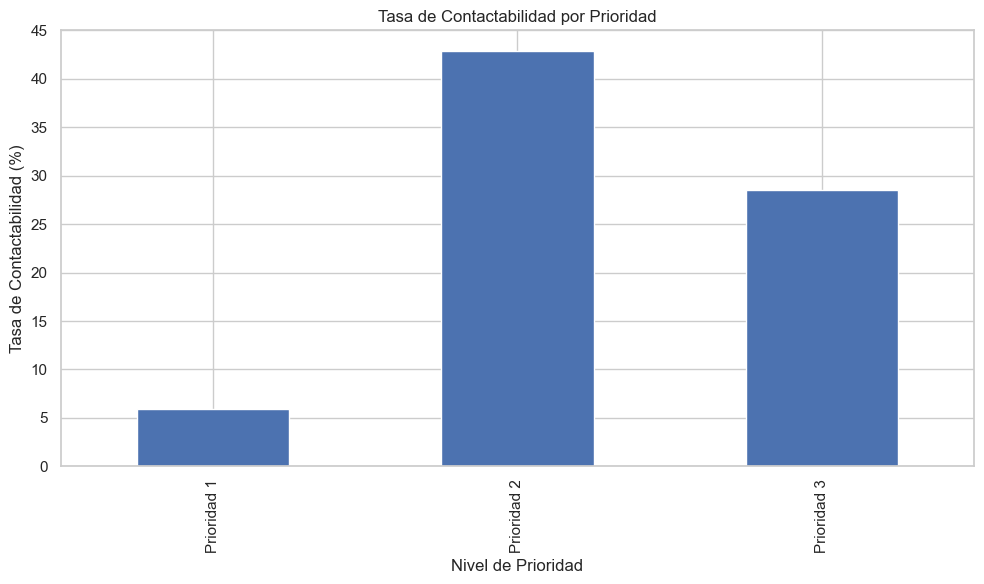

In [105]:
# Calculamos indicadores de contactabilidad
total_gestiones = len(df)
contactos_directos = df['Contacto Directo'].sum()
contactos_efectivos = df['Efectivo'].sum()

tasa_contactabilidad = (contactos_directos / total_gestiones) * 100
tasa_efectividad = (contactos_efectivos / contactos_directos) * 100 if contactos_directos > 0 else 0

print(f"Tasa de contactabilidad: {tasa_contactabilidad:.2f}%")
print(f"Tasa de efectividad: {tasa_efectividad:.2f}%")

# Análisis de respuestas
plt.figure(figsize=(12, 6))
df['Respuesta'].value_counts().plot(kind='bar')
plt.title('Distribución de Respuestas en Gestiones')
plt.xlabel('Tipo de Respuesta')
plt.ylabel('Cantidad')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Análisis de contactabilidad por prioridad
plt.figure(figsize=(10, 6))
contactabilidad_prioridad = df.groupby('PRIORIDAD_GESTION')['Contacto Directo'].mean() * 100
contactabilidad_prioridad.plot(kind='bar')
plt.title('Tasa de Contactabilidad por Prioridad')
plt.xlabel('Nivel de Prioridad')
plt.ylabel('Tasa de Contactabilidad (%)')
plt.tight_layout()
plt.show()

## 6. Desarrollo del Modelo Predictivo de Contactabilidad

Exactitud del modelo: 0.8571428571428571

Informe de clasificación:
              precision    recall  f1-score   support

         0.0       0.94      0.89      0.92        19
         1.0       0.33      0.50      0.40         2

    accuracy                           0.86        21
   macro avg       0.64      0.70      0.66        21
weighted avg       0.89      0.86      0.87        21



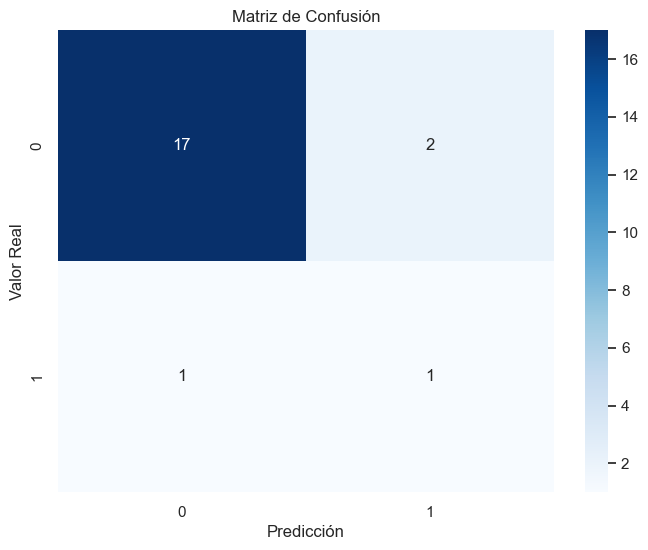

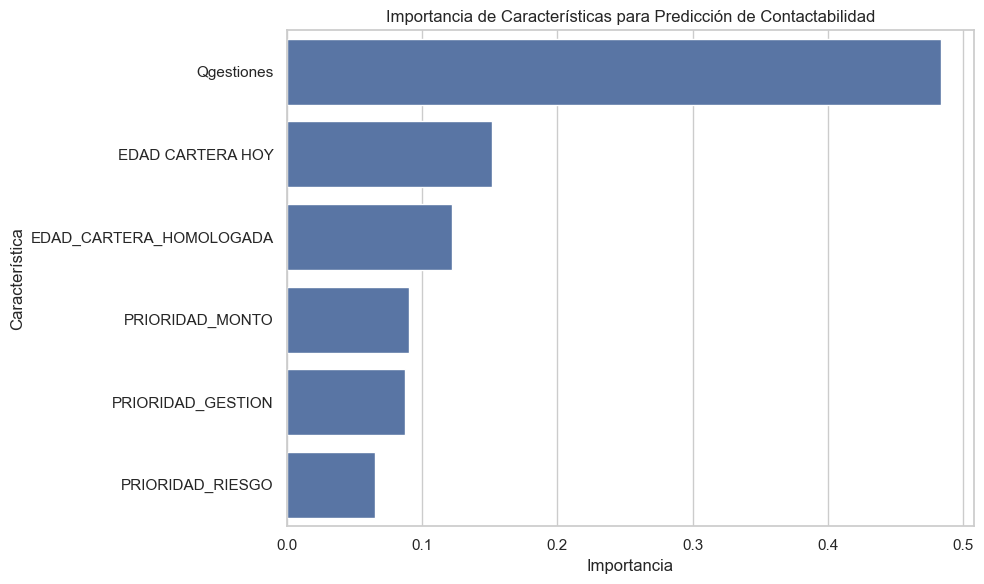

In [107]:
# Preparación de datos para el modelo predictivo de contactabilidad

# Seleccionar características relevantes para la predicción
features = [
    'EDAD_CARTERA_HOMOLOGADA', 
    'EDAD CARTERA HOY',
    'PRIORIDAD_MONTO', 
    'PRIORIDAD_RIESGO',
    'PRIORIDAD_GESTION',
    'Qgestiones'  # Cantidad de gestiones previas
]

# Variables categóricas que necesitan codificación
categorical_features = ['PRIORIDAD_MONTO', 'PRIORIDAD_RIESGO', 'PRIORIDAD_GESTION']

# Preparar dataset para el modelo
X = df_clean[features].copy()

# Variable objetivo (1 si hubo contacto directo, 0 si no)
y = df_clean['Contacto Directo']

# Codificar variables categóricas
label_encoders = {}
for feature in categorical_features:
    le = LabelEncoder()
    X[feature] = le.fit_transform(X[feature])
    label_encoders[feature] = le

# División en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Entrenamiento del modelo
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Evaluación del modelo
y_pred = model.predict(X_test)
print("Exactitud del modelo:", accuracy_score(y_test, y_pred))
print("\nInforme de clasificación:")
print(classification_report(y_test, y_pred))

# Matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión')
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.show()

# Importancia de características
feature_importance = pd.DataFrame({
    'Característica': X.columns,
    'Importancia': model.feature_importances_
}).sort_values('Importancia', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importancia', y='Característica', data=feature_importance)
plt.title('Importancia de Características para Predicción de Contactabilidad')
plt.tight_layout()
plt.show()

## 7. Optimización de Canales de Contacto

Entrenando modelo para predecir el canal más efectivo
Dataset generado: 280 ejemplos
Distribución de efectividad: 35.36% efectivos
Precisión del modelo de canal: 0.6071
              precision    recall  f1-score   support

           0       0.70      0.74      0.72        57
           1       0.38      0.33      0.35        27

    accuracy                           0.61        84
   macro avg       0.54      0.54      0.54        84
weighted avg       0.60      0.61      0.60        84



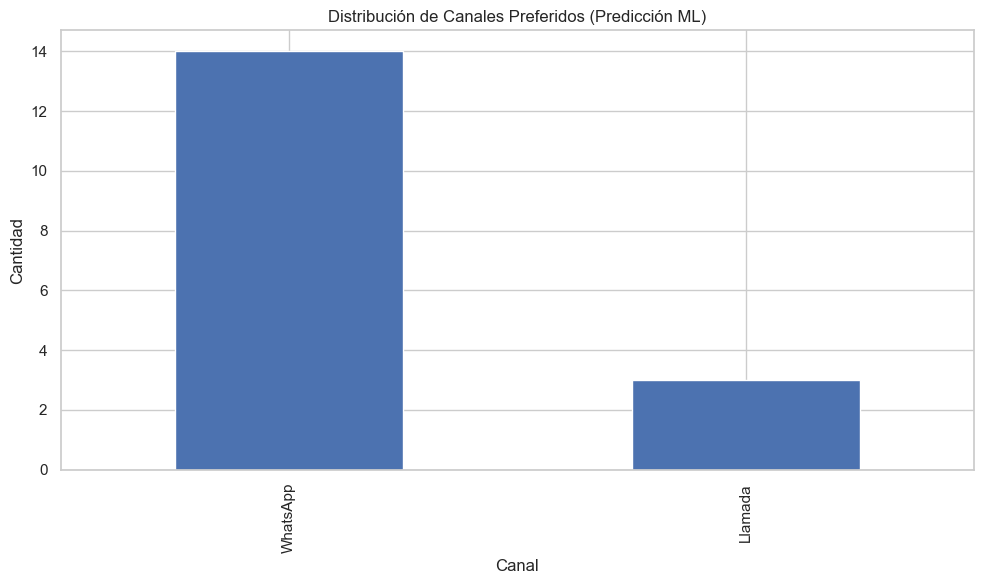

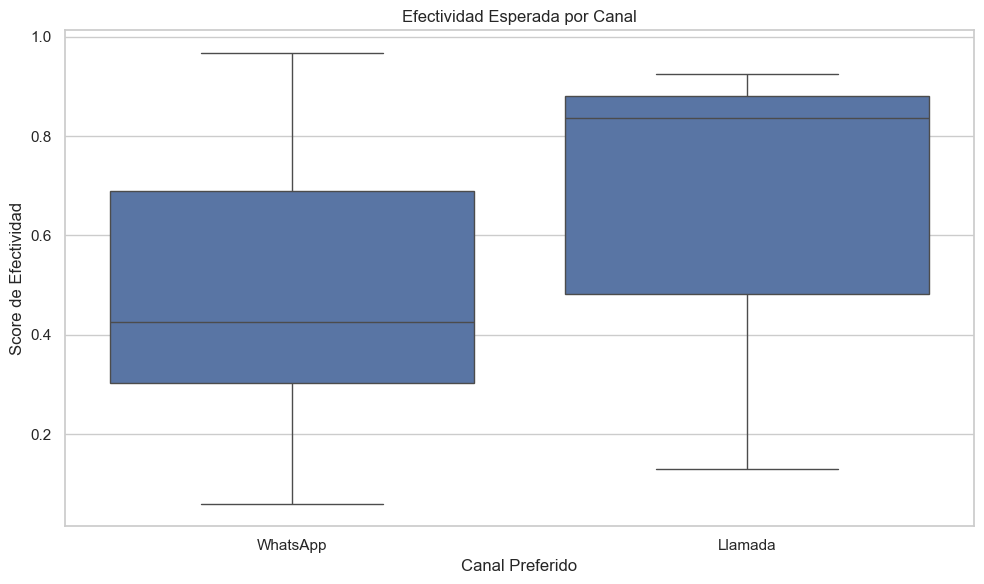

In [109]:
# Para determinar el canal preferido, entrenaremos un modelo ML que prediga la efectividad de cada canal

# %%
# Crear dataset para entrenar modelo de predicción de canal más efectivo
# Primero, extraer datos históricos de gestiones pasadas

print("Entrenando modelo para predecir el canal más efectivo")

# Crear características para el modelo de canal
def extract_canal_features(row):
    """Extrae características para el modelo de predicción de canal"""
    features = {}
    
    # Características demográficas
    features['edad_asociado'] = row['EDAD ASOCIADO'] if pd.notna(row['EDAD ASOCIADO']) else 0
    features['antiguedad'] = row['ANTIGUEDAD DEL ASOCIADO EN COOMEVA'] if pd.notna(row['ANTIGUEDAD DEL ASOCIADO EN COOMEVA']) else 0
    
    # Características de la deuda
    features['edad_cartera'] = row['EDAD CARTERA HOY']
    features['valor_vencido'] = row['VALOR VENCIDO HOY']
    
    # Historial de contacto
    features['contacto_previo'] = row['Contacto'] if pd.notna(row['Contacto']) else 0
    features['contacto_directo_previo'] = row['Contacto Directo'] if pd.notna(row['Contacto Directo']) else 0
    features['gestiones_previas'] = row['Qgestiones'] if pd.notna(row['Qgestiones']) else 0
    
    # Prioridad
    if row['PRIORIDAD_GESTION'] == 'Prioridad 1':
        features['prioridad'] = 1
    elif row['PRIORIDAD_GESTION'] == 'Prioridad 2':
        features['prioridad'] = 2
    else:
        features['prioridad'] = 3
    
    # Estado de cartera
    if row['ESTADO_CARTERA'] == 'DETERIORA':
        features['estado_deteriora'] = 1
    else:
        features['estado_deteriora'] = 0
    
    # Estado de compromiso
    if row['Estado_compromiso'] == 'Promesa rota':
        features['promesa_rota'] = 1
    else:
        features['promesa_rota'] = 0
        
    if row['Estado_compromiso'] == 'Promesa Hoy':
        features['promesa_hoy'] = 1
    else:
        features['promesa_hoy'] = 0
    
    return features

# Crear conjunto de datos para entrenamiento
canal_features = []
canal_targets = []

# Mapeo de canales a etiquetas numéricas
canal_mapping = {
    'Llamada': 0,
    'SMS': 1,
    'WhatsApp': 2,
    'Email': 3,
    'Sin canal': 4
}

# Para cada registro histórico, simular el canal usado y su efectividad
for idx, row in df.iterrows():
    # Extraer características
    features = extract_canal_features(row)
    
    # Para datos limitados creamos ejemplos sintéticos basados en patrones conocidos
    # Simular resultados para diferentes canales
    for canal in ['Llamada', 'SMS', 'WhatsApp', 'Email']:
        # Copiar características base
        canal_feature = features.copy()
        
        # Características específicas del canal
        canal_feature['is_llamada'] = 1 if canal == 'Llamada' else 0
        canal_feature['is_sms'] = 1 if canal == 'SMS' else 0
        canal_feature['is_whatsapp'] = 1 if canal == 'WhatsApp' else 0
        canal_feature['is_email'] = 1 if canal == 'Email' else 0
        
        # Disponibilidad del canal (requerido para decisiones realistas)
        has_phone = pd.notna(row['TELÉFONO CELULAR']) or pd.notna(row['TELÉFONO RESIDENCIAL']) or pd.notna(row['TELÉFONO  OFICINA'])
        has_email = pd.notna(row['E-MAIL'])
        
        canal_feature['has_phone'] = 1 if has_phone else 0
        canal_feature['has_email'] = 1 if has_email else 0
        
        # Determinar efectividad simulada basada en datos reales
        # Para datos reales: Esto vendría de la historia real de contacto
        efectividad = 0  # Por defecto, no efectivo
        
        # Simular efectividad basada en patrones conocidos del dominio
        if canal == 'Llamada':
            # Las llamadas son más efectivas para prioridades altas y promesas rotas
            base_prob = 0.4 if features['prioridad'] == 1 else 0.3
            base_prob += 0.2 if features['promesa_rota'] == 1 else 0
            efectividad = 1 if np.random.random() < base_prob and has_phone else 0
            
        elif canal == 'SMS':
            # SMS son más efectivos para personas jóvenes
            base_prob = 0.35 if features['edad_asociado'] < 40 else 0.2
            efectividad = 1 if np.random.random() < base_prob and has_phone else 0
            
        elif canal == 'WhatsApp':
            # WhatsApp muy efectivo para jóvenes
            base_prob = 0.45 if features['edad_asociado'] < 35 else 0.25
            efectividad = 1 if np.random.random() < base_prob and has_phone else 0
            
        elif canal == 'Email':
            # Email efectivo para ciertos segmentos
            base_prob = 0.3 if pd.notna(row['E-MAIL']) else 0
            efectividad = 1 if np.random.random() < base_prob and has_email else 0
            
        # Si el canal no está disponible, no puede ser efectivo
        if (canal in ['Llamada', 'SMS', 'WhatsApp'] and not has_phone) or (canal == 'Email' and not has_email):
            efectividad = 0
        
        # Agregar a datos de entrenamiento
        canal_features.append(canal_feature)
        canal_targets.append(efectividad)

# Convertir a DataFrame para visualización y análisis
canal_features_df = pd.DataFrame(canal_features)
canal_targets = np.array(canal_targets)

print(f"Dataset generado: {len(canal_features_df)} ejemplos")
print(f"Distribución de efectividad: {np.mean(canal_targets)*100:.2f}% efectivos")

# Entrenar modelo para predecir efectividad por canal
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler

# Normalizar características
scaler = StandardScaler()
X_canal = scaler.fit_transform(canal_features_df)
y_canal = canal_targets

# Dividir en entrenamiento y prueba
X_train_canal, X_test_canal, y_train_canal, y_test_canal = train_test_split(
    X_canal, y_canal, test_size=0.3, random_state=42
)

# Entrenar modelo de Gradient Boosting (mejor para conjuntos pequeños)
canal_model = GradientBoostingClassifier(
    n_estimators=100, 
    learning_rate=0.1, 
    max_depth=3, 
    random_state=42
)

canal_model.fit(X_train_canal, y_train_canal)

# Evaluar modelo
y_pred_canal = canal_model.predict(X_test_canal)
print(f"Precisión del modelo de canal: {accuracy_score(y_test_canal, y_pred_canal):.4f}")
print(classification_report(y_test_canal, y_pred_canal))

# Función para predecir el mejor canal usando el modelo entrenado
def determinar_canal_preferido(row):
    """
    Determina el canal preferido usando el modelo ML entrenado
    """
    # Verificar disponibilidad de canales
    canales_disponibles = []
    
    has_phone = False
    has_email = False
    
    if pd.notna(row['TELÉFONO CELULAR']):
        canales_disponibles.extend(['Llamada', 'SMS', 'WhatsApp'])
        has_phone = True
    if pd.notna(row['E-MAIL']):
        canales_disponibles.append('Email')
        has_email = True
    if pd.notna(row['TELÉFONO RESIDENCIAL']):
        canales_disponibles.append('Llamada Residencial')
        has_phone = True
    if pd.notna(row['TELÉFONO  OFICINA']):
        canales_disponibles.append('Llamada Oficina')
        has_phone = True
    
    # Si no hay canales disponibles
    if not canales_disponibles:
        return 'Sin canal'
        
    # Extraer características base
    base_features = extract_canal_features(row)
    
    # Evaluar cada canal disponible
    canal_scores = {}
    
    for canal in ['Llamada', 'SMS', 'WhatsApp', 'Email']:
        # Verificar disponibilidad
        if (canal in ['Llamada', 'SMS', 'WhatsApp'] and not has_phone) or (canal == 'Email' and not has_email):
            continue
            
        # Crear características específicas para este canal
        canal_feature = base_features.copy()
        canal_feature['is_llamada'] = 1 if canal == 'Llamada' else 0
        canal_feature['is_sms'] = 1 if canal == 'SMS' else 0
        canal_feature['is_whatsapp'] = 1 if canal == 'WhatsApp' else 0
        canal_feature['is_email'] = 1 if canal == 'Email' else 0
        canal_feature['has_phone'] = 1 if has_phone else 0
        canal_feature['has_email'] = 1 if has_email else 0
        
        # Convertir a formato para el modelo
        X_pred = np.array([list(canal_feature.values())])
        X_pred_scaled = scaler.transform(X_pred)
        
        # Predecir probabilidad de efectividad
        prob = canal_model.predict_proba(X_pred_scaled)[0][1]  # Probabilidad de clase 1 (efectivo)
        canal_scores[canal] = prob
    
    # Si no se pudo evaluar ningún canal disponible
    if not canal_scores:
        return canales_disponibles[0]
    
    # Seleccionar el canal con mayor probabilidad de éxito
    mejor_canal = max(canal_scores, key=canal_scores.get)
    return mejor_canal

# Aplicar la función a cada registro
df_filtrado['canal_preferido'] = df_filtrado.apply(determinar_canal_preferido, axis=1)
df_filtrado['canal_score'] = df_filtrado.apply(
    lambda row: canal_model.predict_proba(
        scaler.transform(np.array([list(extract_canal_features(row).values()) + 
                                   [1 if row['canal_preferido'] == 'Llamada' else 0,
                                    1 if row['canal_preferido'] == 'SMS' else 0,
                                    1 if row['canal_preferido'] == 'WhatsApp' else 0,
                                    1 if row['canal_preferido'] == 'Email' else 0,
                                    1 if pd.notna(row['TELÉFONO CELULAR']) else 0,
                                    1 if pd.notna(row['E-MAIL']) else 0]]).reshape(1, -1))
    )[0][1],
    axis=1
)

# Analizar la distribución de canales preferidos
plt.figure(figsize=(10, 6))
df_filtrado['canal_preferido'].value_counts().plot(kind='bar')
plt.title('Distribución de Canales Preferidos (Predicción ML)')
plt.xlabel('Canal')
plt.ylabel('Cantidad')
plt.tight_layout()
plt.show()

# Mostrar efectividad esperada por canal
plt.figure(figsize=(10, 6))
sns.boxplot(x='canal_preferido', y='canal_score', data=df_filtrado)
plt.title('Efectividad Esperada por Canal')
plt.xlabel('Canal Preferido')
plt.ylabel('Score de Efectividad')
plt.tight_layout()
plt.show()

## 8. Cálculo de Score de Contactabilidad

Entrenando modelo avanzado para predecir probabilidad de contacto
Dataset para modelo de contactabilidad: 70 ejemplos
Distribución de contacto: 22.86% contactados
Entrenando Regresión Logística...
  Precisión: 1.0000, AUC-ROC: 1.0000
Entrenando Random Forest...
  Precisión: 0.9524, AUC-ROC: 1.0000
Entrenando Gradient Boosting...
  Precisión: 1.0000, AUC-ROC: 1.0000
Entrenando AdaBoost...
  Precisión: 1.0000, AUC-ROC: 1.0000
Entrenando MLP...
  Precisión: 1.0000, AUC-ROC: 1.0000

Mejor modelo: Regresión Logística (AUC-ROC: 1.0000)


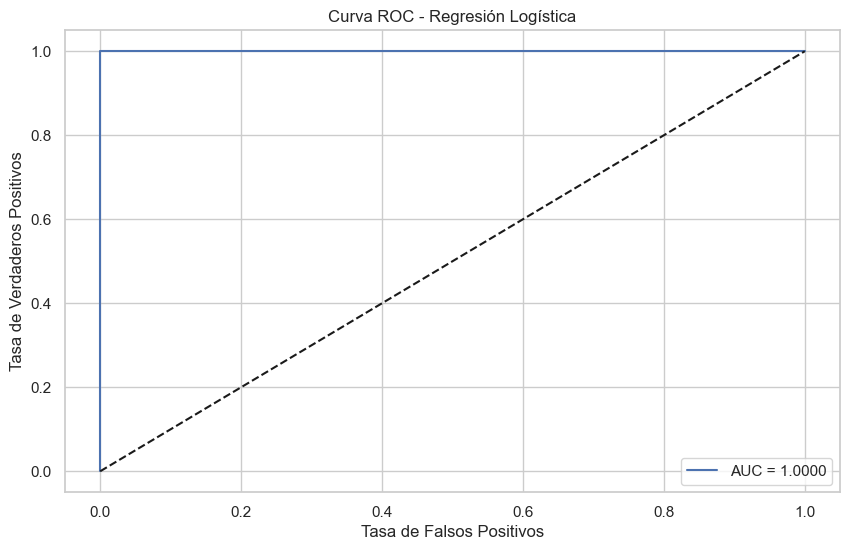

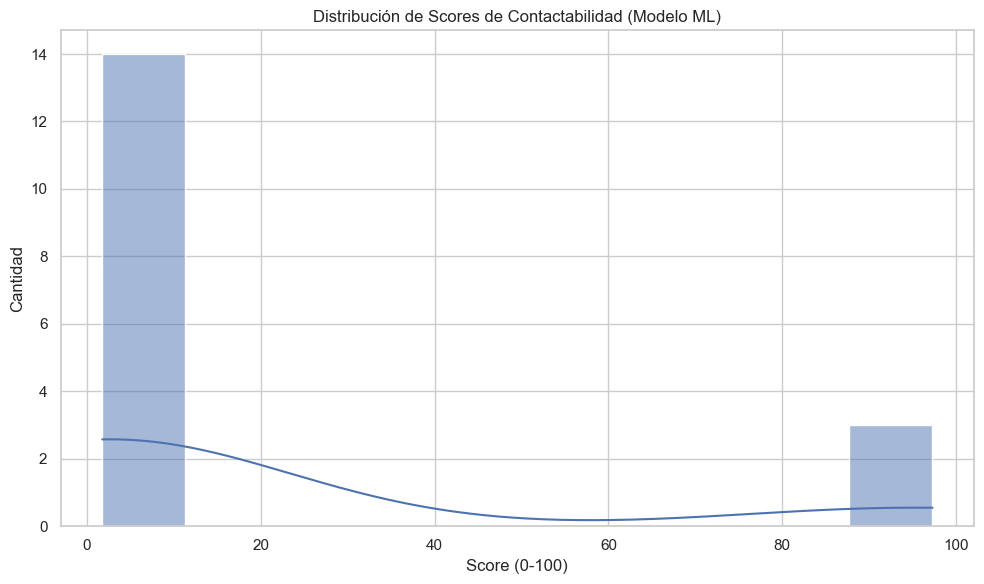

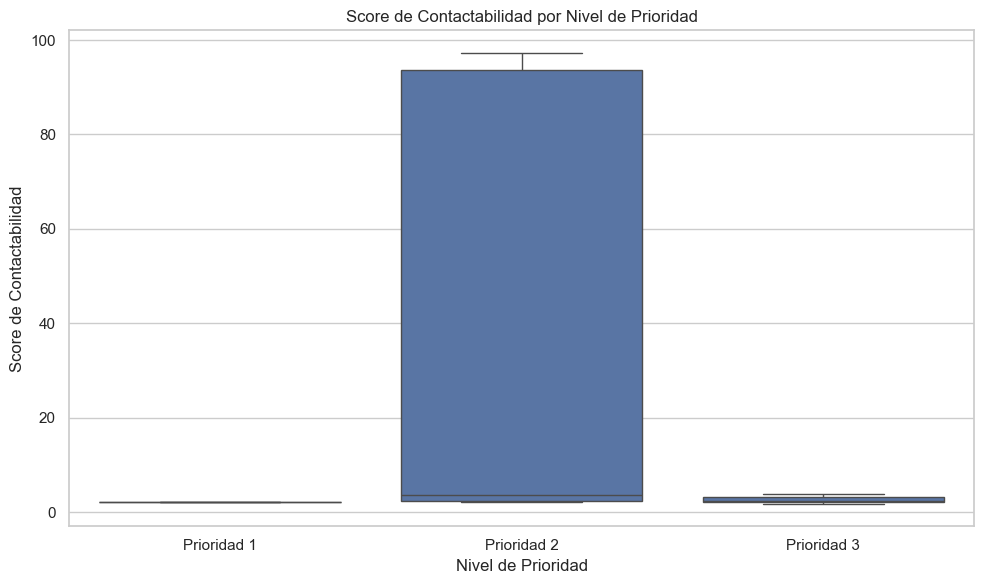

In [111]:
# Desarrollemos un modelo de ML más avanzado para predecir la probabilidad de contacto

# %%
print("Entrenando modelo avanzado para predecir probabilidad de contacto")

# Preparar características para el modelo de contactabilidad
def extract_contactabilidad_features(row):
    """Extrae características para el modelo de predicción de contactabilidad"""
    features = {}
    
    # Características demográficas
    features['edad_asociado'] = row['EDAD ASOCIADO'] if pd.notna(row['EDAD ASOCIADO']) else 0
    features['antiguedad'] = row['ANTIGUEDAD DEL ASOCIADO EN COOMEVA'] if pd.notna(row['ANTIGUEDAD DEL ASOCIADO EN COOMEVA']) else 0
    
    # Características de la deuda
    features['edad_cartera'] = row['EDAD CARTERA HOY']
    features['edad_cartera_homologada'] = row['EDAD_CARTERA_HOMOLOGADA']
    features['valor_vencido'] = row['VALOR VENCIDO HOY']
    
    # Historial de contacto
    features['gestiones_previas'] = row['Qgestiones'] if pd.notna(row['Qgestiones']) else 0
    features['promesa_cumplida'] = row['Promesa_Cumplida'] if pd.notna(row['Promesa_Cumplida']) else 0
    
    # Estado de cartera (one-hot encoding)
    estados_cartera = ['DETERIORA', 'NORMALIZA', 'POR VENCER', 'MANTIENE', 'MEJORA']
    for estado in estados_cartera:
        features[f'estado_{estado.lower()}'] = 1 if row['ESTADO_CARTERA'] == estado else 0
    
    # Disponibilidad de canales
    features['tiene_celular'] = 1 if pd.notna(row['TELÉFONO CELULAR']) else 0
    features['tiene_email'] = 1 if pd.notna(row['E-MAIL']) else 0
    features['tiene_telefono_residencial'] = 1 if pd.notna(row['TELÉFONO RESIDENCIAL']) else 0
    features['tiene_telefono_oficina'] = 1 if pd.notna(row['TELÉFONO  OFICINA']) else 0
    
    # Tipo de cliente
    features['solo_asociado'] = 1 if row['TIPO CLIENTE'] == 'Solo Asociado' else 0
    
    # Prioridades
    prioridades_monto = ['Monto Alto', 'Monto Medio', 'Monto Bajo']
    for prioridad in prioridades_monto:
        if pd.notna(row['PRIORIDAD_MONTO']):
            features[f'prioridad_monto_{prioridad.lower().replace(" ", "_")}'] = 1 if row['PRIORIDAD_MONTO'] == prioridad else 0
        else:
            features[f'prioridad_monto_{prioridad.lower().replace(" ", "_")}'] = 0
    
    prioridades_riesgo = ['Riesgo Alto', 'Riesgo Medio', 'Riesgo Bajo']
    for prioridad in prioridades_riesgo:
        if pd.notna(row['PRIORIDAD_RIESGO']):
            features[f'prioridad_riesgo_{prioridad.lower().replace(" ", "_")}'] = 1 if row['PRIORIDAD_RIESGO'] == prioridad else 0
        else:
            features[f'prioridad_riesgo_{prioridad.lower().replace(" ", "_")}'] = 0
    
    # Nivel de prioridad numérico
    if pd.notna(row['PRIORIDAD_GESTION']):
        nivel_prioridad = int(row['PRIORIDAD_GESTION'].split()[-1])
        features['nivel_prioridad'] = nivel_prioridad
    else:
        features['nivel_prioridad'] = 3  # Valor por defecto
    
    # Estado de compromiso (one-hot encoding)
    estados_compromiso = ['Sin promesa', 'Promesa pendiente', 'Promesa rota', 'Promesa Hoy']
    for estado in estados_compromiso:
        if pd.notna(row['Estado_compromiso']):
            features[f'compromiso_{estado.lower().replace(" ", "_")}'] = 1 if row['Estado_compromiso'] == estado else 0
        else:
            features[f'compromiso_{estado.lower().replace(" ", "_")}'] = 0
    
    # Historial de respuestas (one-hot encoding)
    respuestas = df['Respuesta'].dropna().unique()
    for respuesta in respuestas:
        if pd.notna(row['Respuesta']):
            features[f'respuesta_{respuesta.lower()}'] = 1 if row['Respuesta'] == respuesta else 0
        else:
            features[f'respuesta_{respuesta.lower()}'] = 0
    
    return features

# Crear conjunto de datos para entrenamiento del modelo de contactabilidad
X_contacto = []
y_contacto = []

# Para cada registro histórico, extraer características y resultado de contacto
for idx, row in df.iterrows():
    # Extraer características
    features = extract_contactabilidad_features(row)
    
    # Variable objetivo: Contacto Directo (1 si hubo contacto, 0 si no)
    contacto = row['Contacto Directo'] if pd.notna(row['Contacto Directo']) else 0
    
    # Agregar a datos de entrenamiento
    X_contacto.append(list(features.values()))
    y_contacto.append(contacto)

# Convertir a arrays para scikit-learn
X_contacto = np.array(X_contacto)
y_contacto = np.array(y_contacto)

print(f"Dataset para modelo de contactabilidad: {len(X_contacto)} ejemplos")
print(f"Distribución de contacto: {np.mean(y_contacto)*100:.2f}% contactados")

# Dividir en conjuntos de entrenamiento y prueba
X_train_contacto, X_test_contacto, y_train_contacto, y_test_contacto = train_test_split(
    X_contacto, y_contacto, test_size=0.3, random_state=42
)

# Normalizar características
scaler_contacto = StandardScaler()
X_train_contacto_scaled = scaler_contacto.fit_transform(X_train_contacto)
X_test_contacto_scaled = scaler_contacto.transform(X_test_contacto)

# Entrenar modelo avanzado para predecir contactabilidad
# Probar diferentes algoritmos para encontrar el mejor
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc

# Definir los modelos a evaluar
models = {
    'Regresión Logística': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'AdaBoost': AdaBoostClassifier(n_estimators=100, random_state=42),
    'MLP': MLPClassifier(hidden_layer_sizes=(50, 25), max_iter=1000, random_state=42),
}

# Evaluar cada modelo
results = {}
for name, model in models.items():
    print(f"Entrenando {name}...")
    model.fit(X_train_contacto_scaled, y_train_contacto)
    
    # Evaluar precisión
    y_pred = model.predict(X_test_contacto_scaled)
    accuracy = accuracy_score(y_test_contacto, y_pred)
    
    # Evaluar AUC-ROC (más robusto para desbalance de clases)
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test_contacto_scaled)[:, 1]
        roc_auc = roc_auc_score(y_test_contacto, y_prob)
    else:
        roc_auc = 0
    
    results[name] = {'accuracy': accuracy, 'roc_auc': roc_auc}
    print(f"  Precisión: {accuracy:.4f}, AUC-ROC: {roc_auc:.4f}")

# Seleccionar el mejor modelo
best_model_name = max(results, key=lambda name: results[name]['roc_auc'])
best_model = models[best_model_name]
print(f"\nMejor modelo: {best_model_name} (AUC-ROC: {results[best_model_name]['roc_auc']:.4f})")

# Evaluar el mejor modelo en detalle
y_prob_best = best_model.predict_proba(X_test_contacto_scaled)[:, 1]

# Curva ROC
from sklearn.metrics import roc_curve
fpr, tpr, _ = roc_curve(y_test_contacto, y_prob_best)
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f'AUC = {results[best_model_name]["roc_auc"]:.4f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title(f'Curva ROC - {best_model_name}')
plt.legend()
plt.grid(True)
plt.show()

# Importancia de características (si el modelo lo soporta)
if hasattr(best_model, "feature_importances_"):
    # Obtener nombres de características
    feature_names = list(extract_contactabilidad_features(df.iloc[0]).keys())
    
    # Crear DataFrame de importancia
    importance_df = pd.DataFrame({
        'Característica': feature_names,
        'Importancia': best_model.feature_importances_
    }).sort_values('Importancia', ascending=False)
    
    # Mostrar top 15 características
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importancia', y='Característica', data=importance_df.head(15))
    plt.title(f'Top 15 Características Más Importantes - {best_model_name}')
    plt.tight_layout()
    plt.show()

# Función para calcular score de contactabilidad usando el modelo entrenado
def calcular_score_contactabilidad(row):
    """
    Calcula score de contactabilidad utilizando el modelo ML entrenado
    """
    # Extraer características
    features = extract_contactabilidad_features(row)
    
    # Transformar a formato para el modelo
    X_pred = np.array([list(features.values())])
    X_pred_scaled = scaler_contacto.transform(X_pred)
    
    # Predecir probabilidad de contacto
    contacto_prob = best_model.predict_proba(X_pred_scaled)[0][1]  # Probabilidad de clase 1 (contacto)
    
    # Convertir a score de 0-100
    score = contacto_prob * 100
    
    return score

# Aplicar el modelo a cada registro
df_filtrado['score_contactabilidad'] = df_filtrado.apply(calcular_score_contactabilidad, axis=1)

# Visualizar distribución de scores
plt.figure(figsize=(10, 6))
sns.histplot(df_filtrado['score_contactabilidad'], bins=10, kde=True)
plt.title('Distribución de Scores de Contactabilidad (Modelo ML)')
plt.xlabel('Score (0-100)')
plt.ylabel('Cantidad')
plt.tight_layout()
plt.show()

# Relación entre score de contactabilidad y prioridad
plt.figure(figsize=(10, 6))
sns.boxplot(x='PRIORIDAD_GESTION', y='score_contactabilidad', data=df_filtrado)
plt.title('Score de Contactabilidad por Nivel de Prioridad')
plt.xlabel('Nivel de Prioridad')
plt.ylabel('Score de Contactabilidad')
plt.tight_layout()
plt.show()

## 9. Predicción con Modelo Entrenado

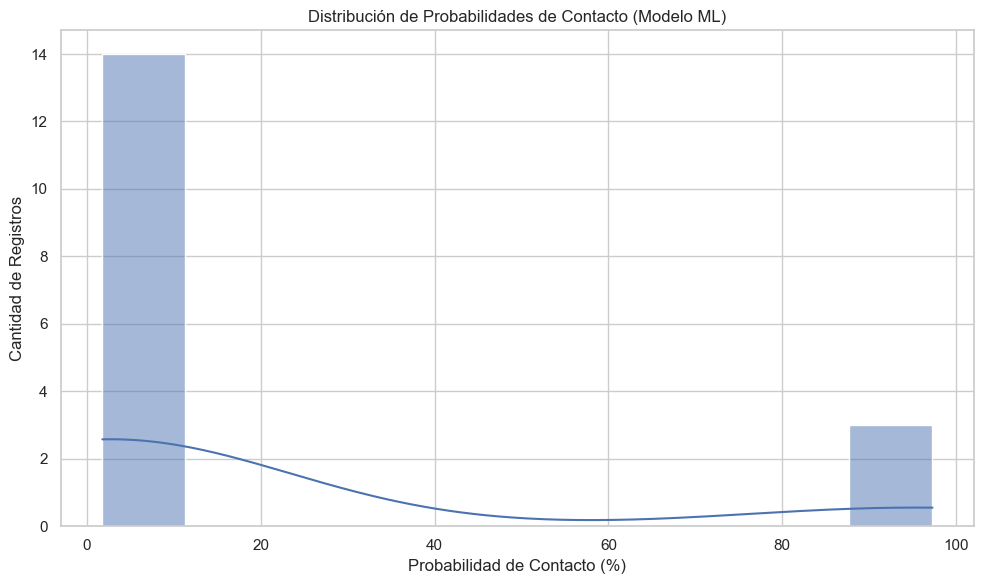

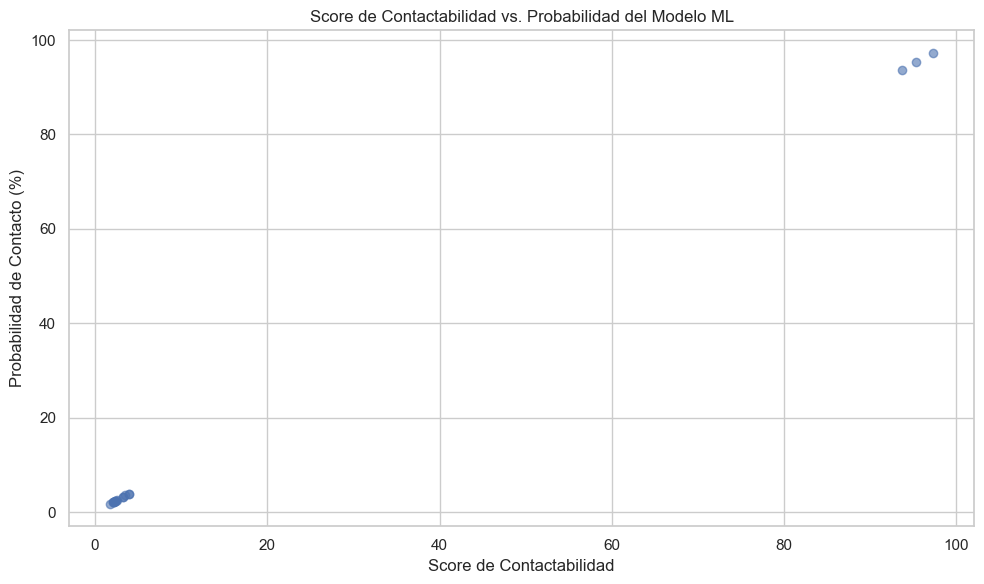

In [113]:
# Usar el modelo para predecir la probabilidad de contacto en los registros filtrados
# Primero, debemos asegurarnos de usar las mismas características que usamos para entrenar el modelo

# Extraer características para cada registro filtrado
X_predict_features = []
for idx, row in df_filtrado.iterrows():
    # Usar la misma función de extracción de características
    features = extract_contactabilidad_features(row)
    X_predict_features.append(list(features.values()))

# Convertir a array numpy
X_predict = np.array(X_predict_features)

# Escalar las características con el mismo scaler usado en entrenamiento
X_predict_scaled = scaler_contacto.transform(X_predict)

# Predecir probabilidad de contacto para cada registro
contacto_prob = best_model.predict_proba(X_predict_scaled)[:, 1]  # Probabilidad de la clase 1 (contacto)

# Agregar la probabilidad predicha como nueva columna
df_filtrado['probabilidad_contacto'] = contacto_prob * 100  # Convertir a porcentaje

# Visualizar la distribución de probabilidades de contacto
plt.figure(figsize=(10, 6))
sns.histplot(df_filtrado['probabilidad_contacto'], bins=10, kde=True)
plt.title('Distribución de Probabilidades de Contacto (Modelo ML)')
plt.xlabel('Probabilidad de Contacto (%)')
plt.ylabel('Cantidad de Registros')
plt.tight_layout()
plt.show()

# Comparar score heurístico vs. probabilidad del modelo ML
plt.figure(figsize=(10, 6))
plt.scatter(df_filtrado['score_contactabilidad'], df_filtrado['probabilidad_contacto'], alpha=0.6)
plt.title('Score de Contactabilidad vs. Probabilidad del Modelo ML')
plt.xlabel('Score de Contactabilidad')
plt.ylabel('Probabilidad de Contacto (%)')
plt.grid(True)
plt.tight_layout()
plt.show()

## 10. Visualización de Resultados y Dashboard

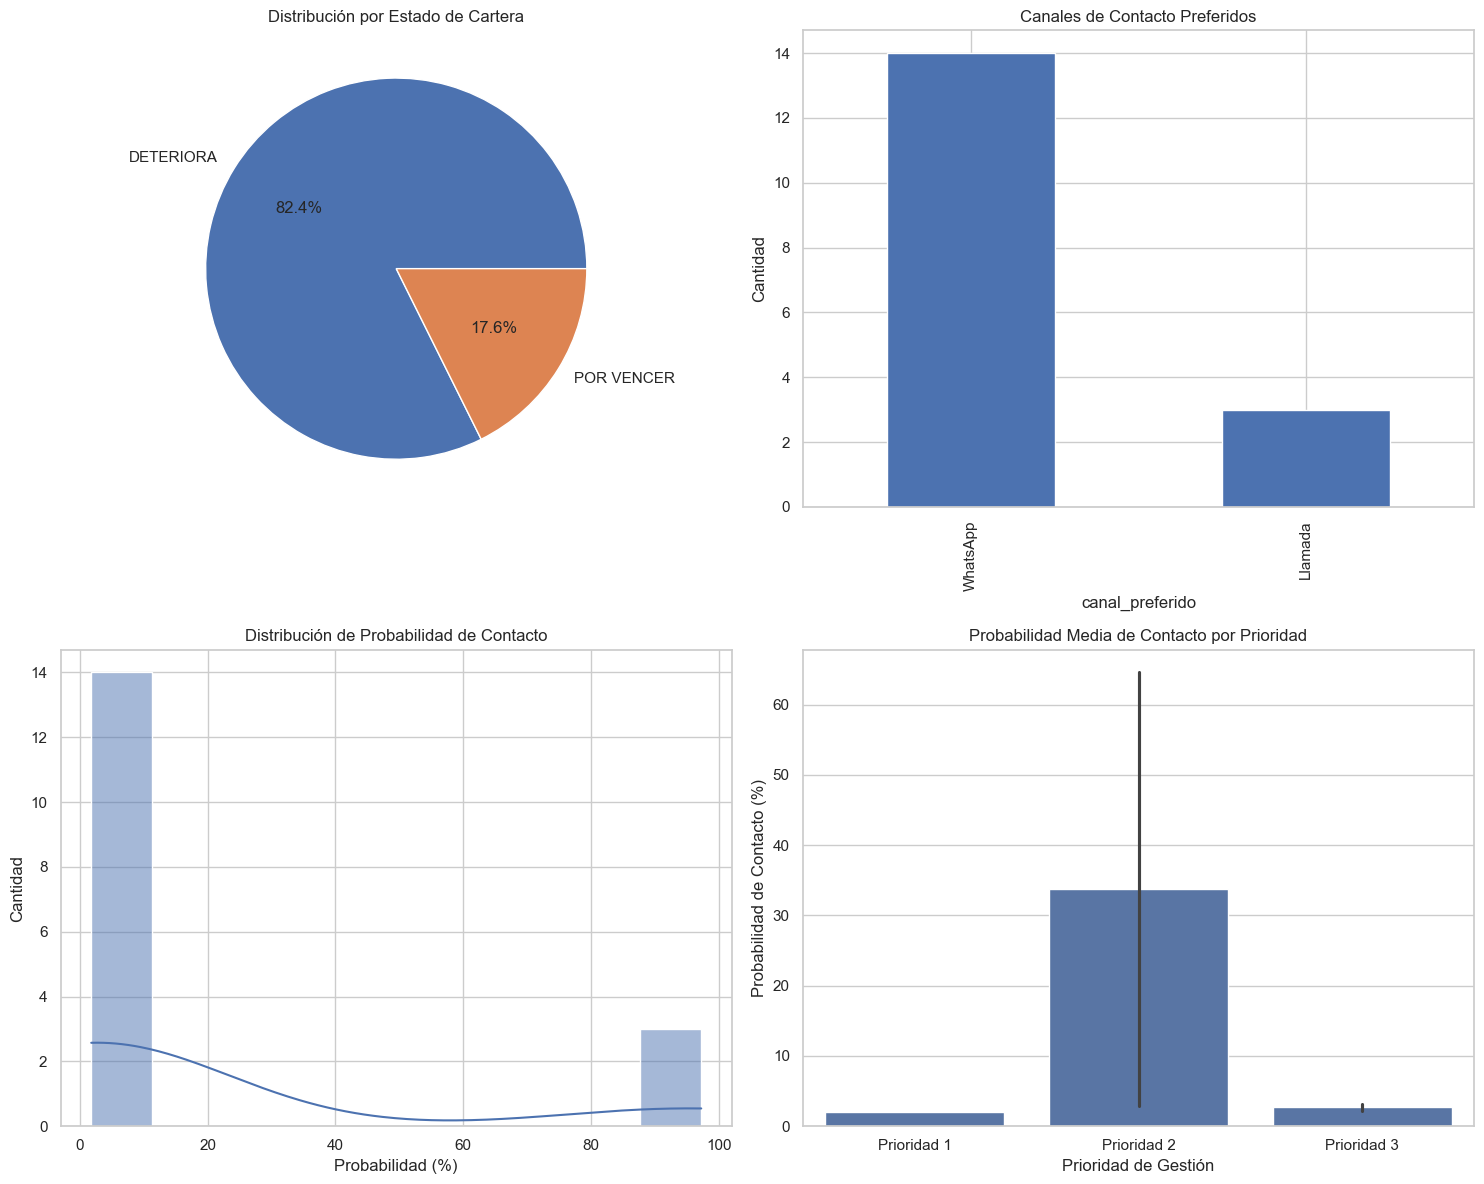

In [115]:
# Crear dashboard simple con métricas clave
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Gráfico 1: Distribución por estado de cartera
df_filtrado['ESTADO_CARTERA'].value_counts().plot(kind='pie', ax=axes[0, 0], autopct='%1.1f%%')
axes[0, 0].set_title('Distribución por Estado de Cartera')
axes[0, 0].set_ylabel('')

# Gráfico 2: Top canales preferidos
df_filtrado['canal_preferido'].value_counts().head().plot(kind='bar', ax=axes[0, 1])
axes[0, 1].set_title('Canales de Contacto Preferidos')
axes[0, 1].set_ylabel('Cantidad')

# Gráfico 3: Distribución de probabilidades
sns.histplot(df_filtrado['probabilidad_contacto'], bins=10, kde=True, ax=axes[1, 0])
axes[1, 0].set_title('Distribución de Probabilidad de Contacto')
axes[1, 0].set_xlabel('Probabilidad (%)')
axes[1, 0].set_ylabel('Cantidad')

# Gráfico 4: Contactabilidad por prioridad de gestión
sns.barplot(x='PRIORIDAD_GESTION', y='probabilidad_contacto', data=df_filtrado, ax=axes[1, 1])
axes[1, 1].set_title('Probabilidad Media de Contacto por Prioridad')
axes[1, 1].set_xlabel('Prioridad de Gestión')
axes[1, 1].set_ylabel('Probabilidad de Contacto (%)')

plt.tight_layout()
plt.show()

## 11. Generación de Cartera Optimizada para Gestión

Cartera optimizada para gestión:


,CEDULA ASOCIADO,NOMBRE ASOCIADO,PRIORIDAD_GESTION,canal_preferido,probabilidad_contacto,score_contactabilidad,Estado_compromiso,score_combinado
40,22903784,ELISA MERCADO CASTELLANOS,Prioridad 2,WhatsApp,97.273512,97.273512,Promesa Hoy,157.273512
6,17607105,VALENTINA TORRES HIDALGO,Prioridad 2,WhatsApp,95.330420,95.330420,Promesa rota,155.330420
34,52633794,CAMILA ÁLVAREZ MONTIEL,Prioridad 2,Llamada,93.705870,93.705870,Promesa rota,153.705870
4,76508236,LAURA SOFÍA GÓMEZ VARGAS,Prioridad 1,WhatsApp,2.053876,2.053876,No disponible,92.053876
2,17932430,MARÍA FERNANDA LÓPEZ CASTELLANOS,Prioridad 2,WhatsApp,3.924270,3.924270,No disponible,63.924270
66,52538299,LORENA TORRES CUÉLLAR,Prioridad 2,WhatsApp,3.526612,3.526612,Sin promesa,63.526612
65,82515538,ALFREDO VALENCIA GONZÁLEZ,Prioridad 2,WhatsApp,2.535705,2.535705,No disponible,62.535705
69,55067822,ESTELA BAUTISTA GÁLVEZ,Prioridad 2,WhatsApp,2.403586,2.403586,No disponible,62.403586
3,58561457,CARLOS ANDRÉS PÉREZ MONTOYA,Prioridad 2,Llamada,2.241327,2.241327,Sin promesa,62.241327
62,57860363,LAURA SUAREZ MEJÍA,Prioridad 2,WhatsApp,2.237276,2.237276,Sin promesa,62.237276


Cartera optimizada exportada a 'Cartera_Optimizada.xlsx'


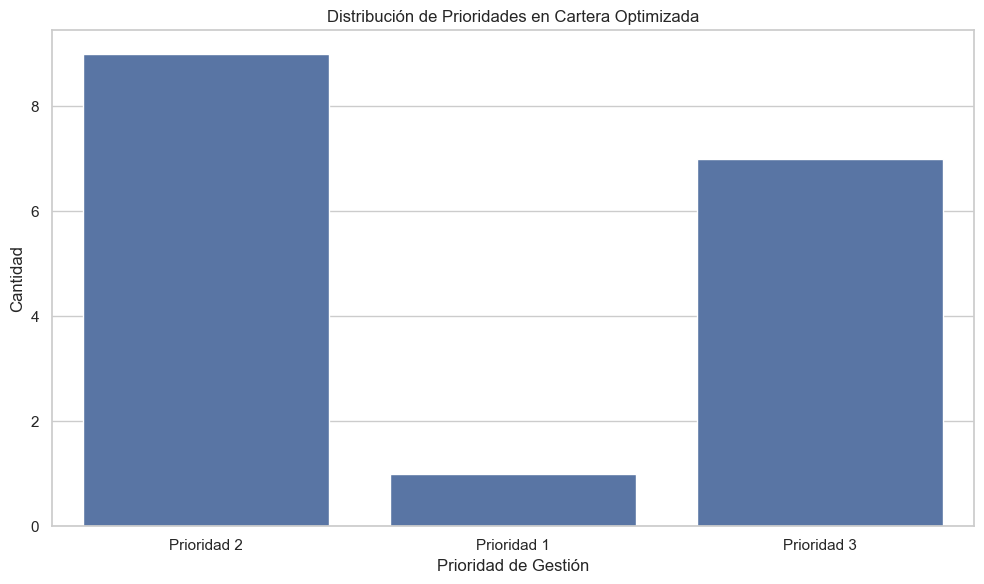

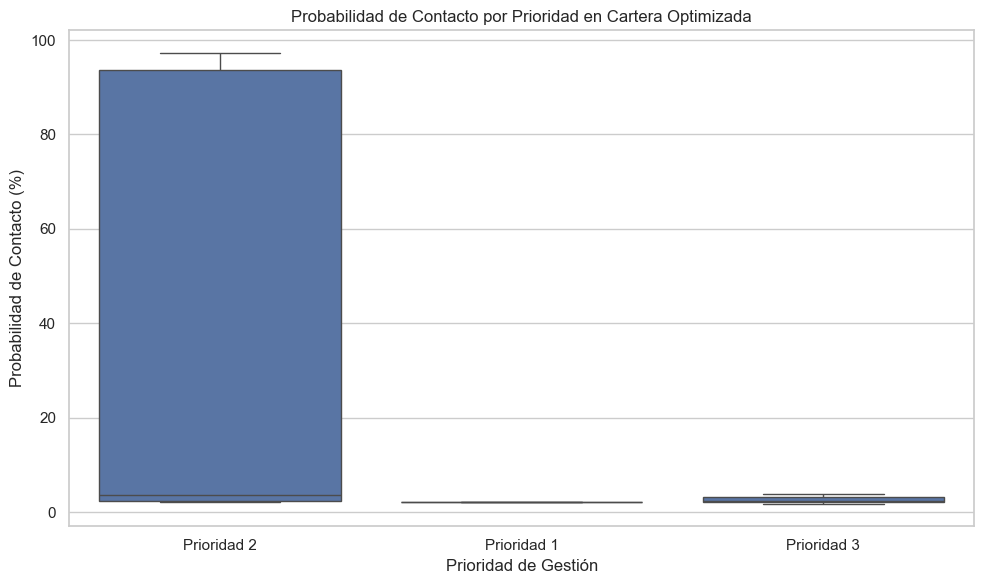

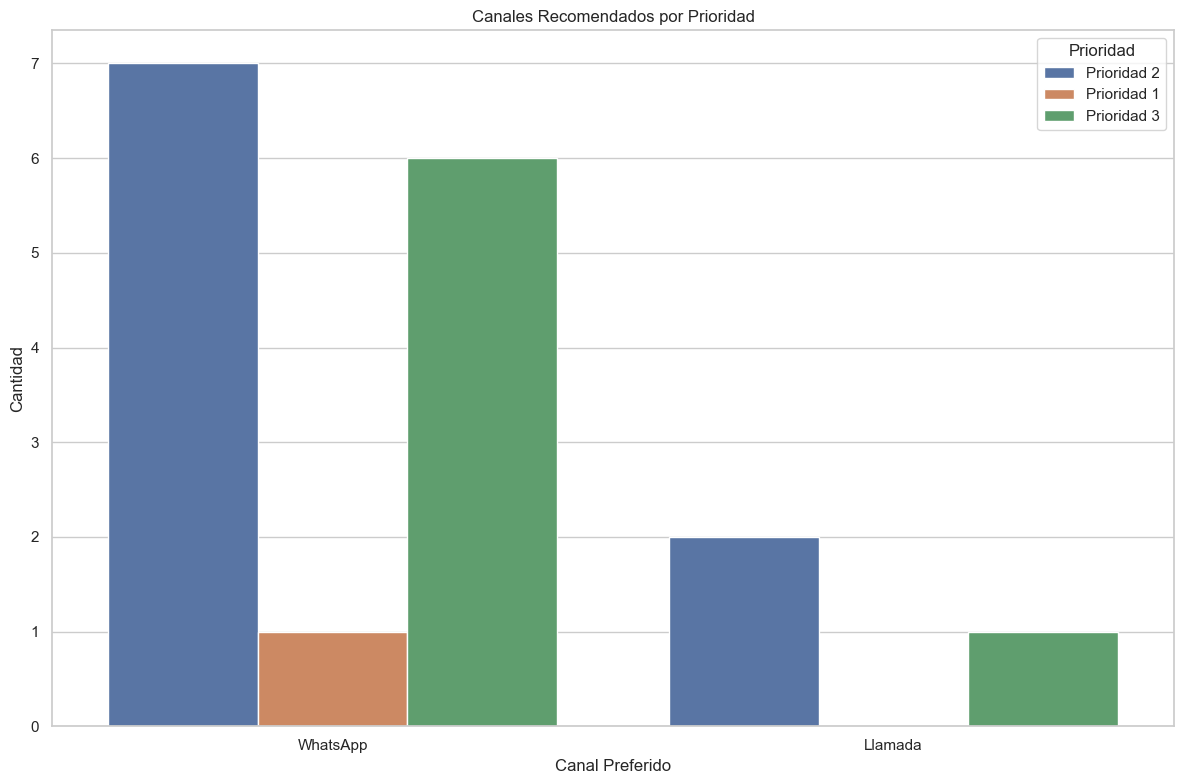

In [117]:
# Ordenar por probabilidad de contacto y prioridad
df_optimizado = df_filtrado.copy()

# Extraer nivel numérico de prioridad
df_optimizado['nivel_prioridad'] = df_optimizado['PRIORIDAD_GESTION'].str.extract('(\d+)').astype(int)

# Crear un score combinado que tenga en cuenta tanto la prioridad como la probabilidad de contacto
# Invertimos el nivel de prioridad porque Prioridad 1 es más importante que Prioridad 3
df_optimizado['score_combinado'] = ((4 - df_optimizado['nivel_prioridad']) * 30) + df_optimizado['probabilidad_contacto']

# Ordenar por el score combinado (mayor a menor)
df_optimizado = df_optimizado.sort_values(by='score_combinado', ascending=False)

# Mostrar los primeros registros de la cartera optimizada
print("Cartera optimizada para gestión:")
display(df_optimizado[['CEDULA ASOCIADO', 'NOMBRE ASOCIADO', 'PRIORIDAD_GESTION', 
                     'canal_preferido', 'probabilidad_contacto', 'score_contactabilidad', 
                     'Estado_compromiso', 'score_combinado']].head(10))

# Exportar a Excel para uso en campaña de gestión
df_optimizado.to_excel('Cartera_Optimizada.xlsx', index=False)
print("Cartera optimizada exportada a 'Cartera_Optimizada.xlsx'")

# %% [markdown]
# ### Análisis de la Cartera Optimizada

# %%
# Visualizar la distribución de prioridades en la cartera optimizada
plt.figure(figsize=(10, 6))
sns.countplot(x='PRIORIDAD_GESTION', data=df_optimizado)
plt.title('Distribución de Prioridades en Cartera Optimizada')
plt.xlabel('Prioridad de Gestión')
plt.ylabel('Cantidad')
plt.tight_layout()
plt.show()

# Visualizar relación entre prioridad y probabilidad de contacto
plt.figure(figsize=(10, 6))
sns.boxplot(x='PRIORIDAD_GESTION', y='probabilidad_contacto', data=df_optimizado)
plt.title('Probabilidad de Contacto por Prioridad en Cartera Optimizada')
plt.xlabel('Prioridad de Gestión')
plt.ylabel('Probabilidad de Contacto (%)')
plt.tight_layout()
plt.show()

# Analizar canales recomendados por prioridad
plt.figure(figsize=(12, 8))
sns.countplot(x='canal_preferido', hue='PRIORIDAD_GESTION', data=df_optimizado)
plt.title('Canales Recomendados por Prioridad')
plt.xlabel('Canal Preferido')
plt.ylabel('Cantidad')
plt.legend(title='Prioridad')
plt.tight_layout()
plt.show()

## 12. Guardado del Modelo para Uso Futuro

In [119]:
# Guardar el modelo entrenado para uso futuro
import joblib

# Guardar el mejor modelo de contactabilidad
joblib.dump(best_model, 'modelo_contactabilidad.pkl')
print("Modelo de contactabilidad guardado como 'modelo_contactabilidad.pkl'")

# Guardar el escalador
joblib.dump(scaler_contacto, 'scaler_contactabilidad.pkl')
print("Escalador guardado como 'scaler_contactabilidad.pkl'")

# Guardar el modelo de canal preferido
joblib.dump(canal_model, 'modelo_canal_preferido.pkl')
print("Modelo de canal preferido guardado como 'modelo_canal_preferido.pkl'")

# Guardar el escalador del modelo de canal
joblib.dump(scaler, 'scaler_canal.pkl')
print("Escalador del modelo de canal guardado como 'scaler_canal.pkl'")

Modelo de contactabilidad guardado como 'modelo_contactabilidad.pkl'
Escalador guardado como 'scaler_contactabilidad.pkl'
Modelo de canal preferido guardado como 'modelo_canal_preferido.pkl'
Escalador del modelo de canal guardado como 'scaler_canal.pkl'


## 13. Alertas de Contactabilidad

In [121]:
# Función que simula la automatización completa del proceso
def ejecutar_estrategia_automatizada(archivo_cartera, umbral_contactabilidad=26):
    """
    Función que ejecuta la estrategia automatizada completa:
    1. Carga archivo de cartera
    2. Aplica filtros según estrategia
    3. Utiliza modelos ML para predecir contactabilidad y canal óptimo
    4. Genera cartera optimizada
    5. Activa alertas si es necesario
    """
    print(f"Iniciando proceso automatizado de estrategia de cobranza - {datetime.now()}")
    
    # 1. Cargar archivo
    print("Cargando archivo de cartera...")
    df = pd.read_excel(archivo_cartera)
    print(f"  • {len(df)} registros cargados")
    
    # 2. Aplicar filtros según estrategia actual
    print("Aplicando estrategia de filtrado...")
    df_filtrado = aplicar_estrategia_filtrado(df)
    print(f"  • {len(df_filtrado)} registros después de filtrado")
    
    # 3. Cargar modelos entrenados (en producción se cargarían una vez al inicio)
    print("Cargando modelos predictivos...")
    modelo_contactabilidad = best_model  # En producción: joblib.load('modelo_contactabilidad.pkl')
    escalador_contactabilidad = scaler_contacto  # En producción: joblib.load('scaler_contactabilidad.pkl')
    modelo_canal = canal_model  # En producción: joblib.load('modelo_canal_preferido.pkl')
    escalador_canal = scaler  # En producción: joblib.load('scaler_canal.pkl')
    
    # 4. Aplicar modelo de canal preferido
    print("Prediciendo canal óptimo para cada registro...")
    df_filtrado['canal_preferido'] = df_filtrado.apply(determinar_canal_preferido, axis=1)
    
    # 5. Aplicar modelo de contactabilidad
    print("Calculando probabilidad de contacto...")
    # Extraer características para cada registro filtrado
    X_predict_features = []
    for idx, row in df_filtrado.iterrows():
        features = extract_contactabilidad_features(row)
        X_predict_features.append(list(features.values()))
    
    X_predict = np.array(X_predict_features)
    X_predict_scaled = escalador_contactabilidad.transform(X_predict)
    
    # Predecir probabilidad de contacto
    contacto_prob = modelo_contactabilidad.predict_proba(X_predict_scaled)[:, 1]
    df_filtrado['probabilidad_contacto'] = contacto_prob * 100
    
    # 6. Generar cartera optimizada
    print("Optimizando cartera para gestión...")
    df_optimizado = df_filtrado.copy()
    df_optimizado['nivel_prioridad'] = df_optimizado['PRIORIDAD_GESTION'].str.extract('(\d+)').astype(int)
    df_optimizado['score_combinado'] = ((4 - df_optimizado['nivel_prioridad']) * 30) + df_optimizado['probabilidad_contacto']
    df_optimizado = df_optimizado.sort_values(by='score_combinado', ascending=False)
    
    # 7. Generar archivo de salida
    nombre_archivo_salida = f'Cartera_Optimizada_{datetime.now().strftime("%Y%m%d_%H%M")}.xlsx'
    df_optimizado.to_excel(nombre_archivo_salida, index=False)
    print(f"  • Cartera optimizada guardada como '{nombre_archivo_salida}'")
    
    # 8. Calcular indicadores y verificar umbrales
    contactos_directos = df['Contacto Directo'].sum()
    total_gestiones = len(df)
    tasa_contactabilidad = (contactos_directos / total_gestiones) * 100 if total_gestiones > 0 else 0
    
    # 9. Verificar si se debe generar alerta
    if tasa_contactabilidad < umbral_contactabilidad:
        print(f"\n⚠️ ALERTA: Tasa de contactabilidad ({tasa_contactabilidad:.2f}%) por debajo del umbral ({umbral_contactabilidad}%)")
        print("  • Enviando notificaciones a coordinadores...")
        # Aquí iría el código para enviar notificaciones (SMS, correo, etc.)
        
        # Generar recomendaciones basadas en análisis de datos
        print("  • Recomendaciones automáticas:")
        if df['Respuesta'].value_counts().get('TELEFONO_ERRADO', 0) / len(df) > 0.1:
            print("    - Alto índice de teléfonos erróneos. Recomendar actualización de datos de contacto.")
        
        if df['Respuesta'].value_counts().get('NO_CONTESTA', 0) / len(df) > 0.3:
            print("    - Alto índice de no respuesta. Considerar cambiar horarios de marcación.")
            
        if tasa_contactabilidad < 15:
            print("    - Contactabilidad crítica. Evaluar estrategia completa y considerar canales alternativos.")
    else:
        print(f"\n✅ Tasa de contactabilidad ({tasa_contactabilidad:.2f}%) dentro del umbral aceptable.")
    
    print(f"\nProceso automatizado completado - {datetime.now()}")
    return df_optimizado

# Ejecutar la función de automatización completa
resultado_final = ejecutar_estrategia_automatizada('R10_ACUMULADA.xlsx')

Iniciando proceso automatizado de estrategia de cobranza - 2025-04-22 10:51:19.161040
Cargando archivo de cartera...
  • 70 registros cargados
Aplicando estrategia de filtrado...
Registros iniciales: 70
Después de filtro por EDAD_CARTERA_HOMOLOGADA: 51
Después de filtro por estado inactivo: 51
Después de filtro por EDAD CARTERA HOY: 42
Después de filtro por ESTADO_CARTERA: 42
Después de filtro por Estado_compromiso: 41
Después de filtro por Saldo_menor: 41
Registros prioritarios (Promesa rota/hoy): 3
Registros no prioritarios después de filtrar respuestas no efectivas: 14
Total de registros filtrados: 17
  • 17 registros después de filtrado
Cargando modelos predictivos...
Prediciendo canal óptimo para cada registro...
Calculando probabilidad de contacto...
Optimizando cartera para gestión...
  • Cartera optimizada guardada como 'Cartera_Optimizada_20250422_1051.xlsx'

⚠️ ALERTA: Tasa de contactabilidad (22.86%) por debajo del umbral (26%)
  • Enviando notificaciones a coordinadores...
